In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import zipfile
import os
import tarfile

from scipy import ndimage
from tensorflow.keras import regularizers
from urllib.request import urlretrieve
from scipy.io import loadmat

tf.keras.backend.set_floatx('float64')
sunspots_file = "sunspots.csv"

# Download data

In [2]:
url = "https://storage.googleapis.com/kagglesdsdata/datasets/2418/917074/Sunspots.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586472062&Signature=CC1HrFyLjRKiYDaHQuTQ6enN0a%2FP%2FLZYhVbIeSHi5zxOsKhNZmWsuCVPOIiZNzv6%2FqjQYTKFD2jNvF1qxtYN%2BKzPH0POT8Q4hjBgF%2BFj4GFVOtWsLP5JJqFzI46u9IZpJrSbnRu7rpIe5D%2FBovopNOpbp0zSpkoTTAIEDMJcQ%2BeRrYdFPKxe8CPr4gou7AzYW%2FC3zxDVxXAO8iJotXGIlkgDuzb2fFR425fNGd69QUFaZl0brcAA5ASywqbutGufRVkiJQWN6ig9t%2B3zvBDy0pf%2F%2FQBsLnCWb791uVSawwfkg8jQeLep%2Fej0%2BMwWXJQovnxNry1WKFe6dpoBQPZrlw%3D%3D&response-content-disposition=attachment%3B+filename%3DSunspots.csv"
urlretrieve(url, sunspots_file)

('sunspots.csv', <http.client.HTTPMessage at 0x7f91685500b8>)

# Read data

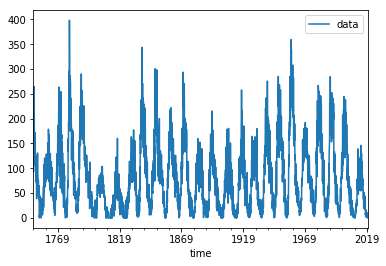

In [11]:
import datetime
import pandas as pd

time_series = []
with open(sunspots_file, "r") as f:
    f.readline()
    for line in f:
        line = line.strip()
        i, date, mean = line.split(',')
        mean = float(mean)
        date = datetime.datetime.strptime(date, "%Y-%m-%d")
        time_series.append((date, mean))
        

df = pd.DataFrame(time_series, columns=['time','data']).set_index('time')
df.plot()
plt.show()

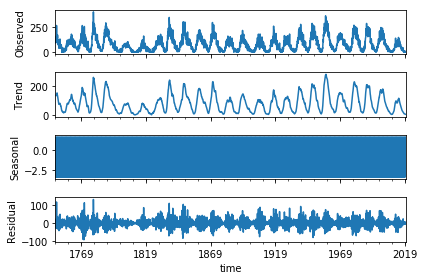

In [12]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df)
decomposition.plot()
plt.show()

# Split train test

In [13]:
series_len = len(df)
test_len = int(series_len * 0.1)
train_len = series_len - test_len
val_len = int(train_len * 0.1)
train = df.iloc[:-test_len, :]
test = df.iloc[-test_len:, :]
val = train.iloc[-val_len:, :]
train = train.iloc[:-val_len, :]

train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

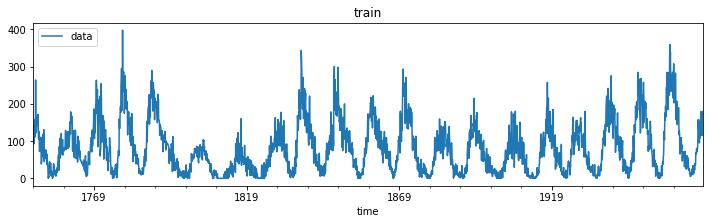

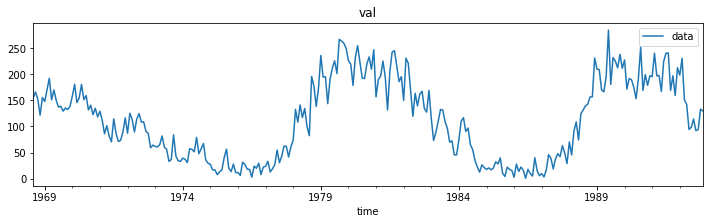

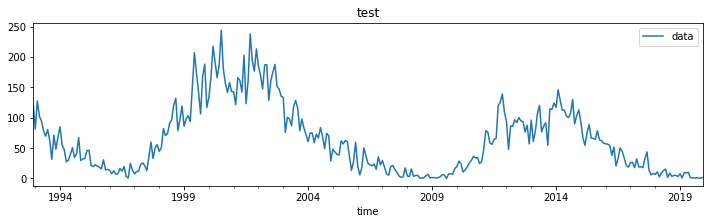

In [18]:
train.plot(figsize=(12,3), title='train')
val.plot(figsize=(12,3), title='val')
test.plot(figsize=(12,3), title='test')
plt.show()

# Arima

In [19]:
from sklearn.metrics import  mean_squared_error 
from statsmodels.tsa.arima_model import ARIMA

X = df.values
train_size = int(len(X) * 0.8)
train_values, test_values = X[0:train_size], X[train_size:len(X)]
history = [x for x in train_values]
arima_predictions = list()
for t in range(len(test_values)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    arima_predictions.append(output[0])
    history.append(test_values[t])

/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Test MSE: 538.131


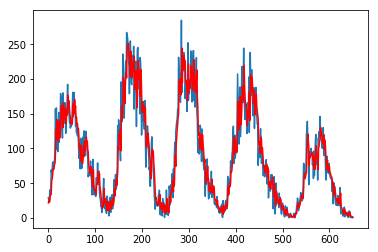

In [20]:
error = mean_squared_error(test_values, arima_predictions)
print('Test MSE: %.3f' % error)

plt.plot(test_values)
plt.plot(arima_predictions, color='red')
plt.show()

# RNN model

In [45]:
def create_dataset(series, time_steps):
    X = []
    y = []
    for i in range(len(series) - time_steps):
        x = series[i:i + time_steps]
        x = np.array(x).reshape(time_steps, 1)
        prediction = series[i + time_steps]
        X.append(x)
        y.append(prediction)
    return np.array(X), np.array(y)

time_steps = 25
x_train, y_train = create_dataset(list(train.values), time_steps)
x_val, y_val = create_dataset(list(val.values), time_steps)
x_test, y_test = create_dataset(list(test.values), time_steps)

print(x_train.shape)
print("Train size: %d, test size: %d, val size: %d" % (len(x_train), len(x_test), len(x_val)))

(2610, 25, 1)
Train size: 2610, test size: 300, val size: 267


In [48]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTMCell, RNN, LSTM, Dense, Dropout

batch_size = 32
series_input = Input(shape=(time_steps, 1, ))

cells = [
    LSTMCell(64),
    LSTMCell(64),
    LSTMCell(128),
]

model = RNN(cells)(series_input)
model = Dropout(0.3)(model)
model = Dense(128)(model)
model = Dense(64)(model)
prediction = Dense(1)(model)
model = Model(series_input, prediction)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 25, 1)]           0         
_________________________________________________________________
rnn_6 (RNN)                  (None, 128)               148736    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 173,569
Trainable params: 173,569
Non-trainable params: 0
_____________________________________________________

In [49]:
history = model.fit(
    x_train, y_train,
    epochs=4,
    batch_size=16,
    validation_data=(x_val, y_val),
    verbose=1
)

Train on 2610 samples, validate on 267 samples
Epoch 1/4
2610/2610 [==============================] - 9s 3ms/sample - loss: 34.9888 - val_loss: 20.8313
Epoch 2/4
2610/2610 [==============================] - 6s 2ms/sample - loss: 20.0548 - val_loss: 24.1033
Epoch 3/4
2610/2610 [==============================] - 6s 2ms/sample - loss: 19.9790 - val_loss: 20.8491
Epoch 4/4
2610/2610 [==============================] - 6s 2ms/sample - loss: 19.5697 - val_loss: 21.8428


300/300 [==============================] - 0s 532us/sample - loss: 13.3840


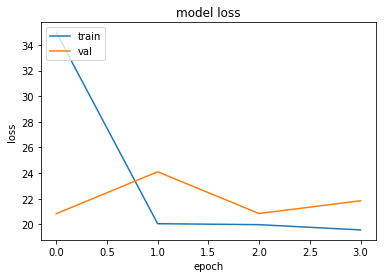

In [50]:
model.evaluate(x_test, y_test)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['train', 'val'], loc='upper left')
plt.show()

Test MSE: 404.782


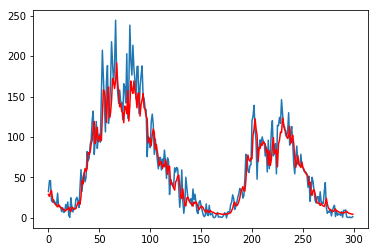

In [51]:
predictions = model.predict(x_test)
error = mean_squared_error(y_test, predictions)
print('Test MSE: %.3f' % error)
plt.plot(y_test)
plt.plot(predictions, color='red')
plt.show()